## Feature extraction from infrared sky images for solar energy estimation

In recent years the idea of a transition to renewable energy sources has progressively gained more strength. Within this movement, solar energy is classified as one of the most important, being a clean alternative to traditional electricity generation systems.

To maximize solar energy production, it is important to have information on atmospheric conditions, especially incident solar radiation. Satellite images have been used to study atmospheric features such as cloud cover and solar radiation estimates. In this field, sky cameras have emerged as a promising technology to study sky conditions with greater precision. These cameras offer a view of the sky with high spatial resolution. Combining satellite images and sky cameras has proven effective in predicting the presence of clouds in the short term. [1] This information is key to adapt the operation of solar power plants to meteorological conditions and achieve better integration of the electricity generated into the grid. 

https://www.sciencedirect.com/science/article/abs/pii/S0169809512001342?via%3Dihub

The objective of this work is to extract features from images gathered with an infrared sky cam on panoramic sky images, for intra-hour solar estiamtion. To achieve this several techniques from image analysis and vision image will be implemented into a single pipeline to obtain the relevant data for further use as inputs in solar prediction models. 

### 1. Image preprocessing 

For this specific work the images received were formated as .jp2 files, to handle this type of files the `imageio` library was used. The file type that is loaded is of type `Uint16`.

uint16


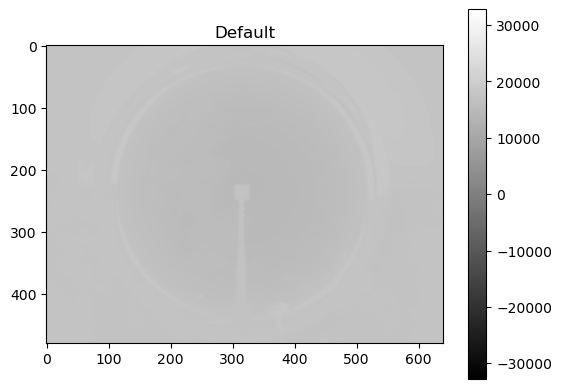

In [164]:
import imageio.v2 as imageio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# path to jp2 image
filepath = '20230807/20230807152030.jp2'

# Read the JP2 image
image = imageio.imread(filepath)
print(image.dtype)
# Showing image in default range
plt.imshow(image.astype(int), cmap="gray", vmin=(-2**16)/2-1, vmax=(2**16)/2-1)
plt.title("Default")
plt.colorbar()


Matplotlib by default makes a normalization process when displaying images, by linearly mapping the minimun and maximum values of the image to the `[0.0, 1.0]` interval. To view the image in better detail a color mapping can be applied. In the following example `jet` mapping is applied. Note that the image values in the `img` variable remain unchanged, however the image shown is in the range of `[14537, 18358]`, corresponding to the min and max values of the given image.

14537
18358


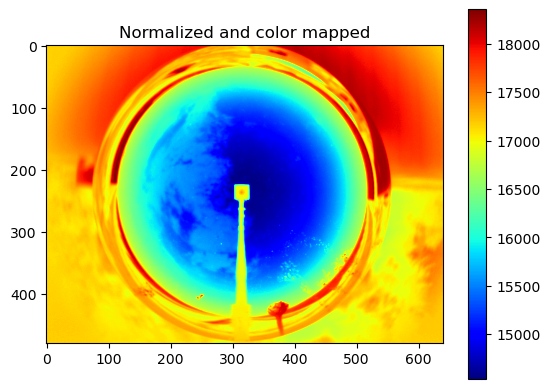

In [165]:
print(np.min(image))
print(np.max(image))
plt.imshow(image.astype(int), cmap="jet")
plt.title("Normalized and color mapped")
plt.colorbar()

`Uint16` is sometimes not the best way to work with image data, for ease of use in the following sections the img variable can be converted to `int32` instead.

In [166]:
# Image gets converted to int32
int_img = image.astype(int)
print(int_img.dtype)

int32


### 2. Image segmentation

The first step in the process of data extraction is to segment the clouds in the image. Several techniques can be applied to achieve this result. This approach consists of removing the background outside of the panoramic mirror as well as the camera with the camera stick. The resulting image then gets brightness adjusted by multiplying radial gradients, followed by a binarization based on brightness. 

The first step was removing the camera and the camera stick. For this part, a mask was previously made and saved in the file `camera.png`. The process consists of dividing the alpha channel of this file by 255, essentialy leaving only ones and zeros. This resulting alpha channel then gets multiplied to the image to process, then the zeros of the image get replaced to match the brightness of the lowest value -1 (unless its zero, which was never the case for all the captured images). 

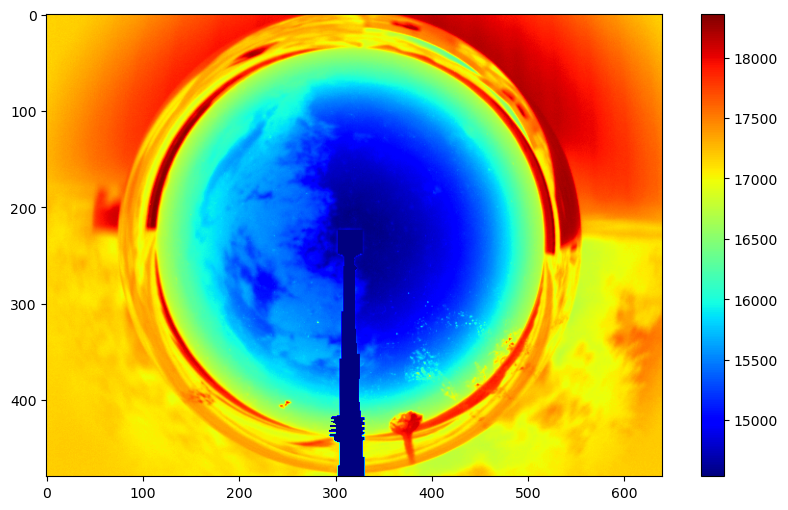

In [167]:
# # camera mask is multiplied to the image to make it the darkest part of it by -1
camara = Image.open('camera.png')
camara = np.asarray(camara)
# Only the alpha channel is needed, and is divided by 255 to get the number in the range [0,1]
slicee = camara[:,:,3]/255
img = int_img * slicee
img[img<1000] = np.max(np.min(int_img) - 1, 0)

plt.figure(figsize=(10,6))
plt.imshow(img, cmap="jet")
plt.colorbar()


The next step is to generate the radial gradients to multiply with the input image. This multiplication was done with the library blend modes. The library only accepts RGBA images as input, the current image is a single channel only, so the RGB layers are duplicates of this channel and the alpha layer is set to a constant opaque layer of ones. For this step the image itself was rescaled to be in the range of `[0,255]`, this step makes it lose some data from the original step, however it is neccesary as some functions only take as input images in the 8 bit range per channel.

(480, 640, 4)


Text(0.5, 1.0, 'Alpha channel')

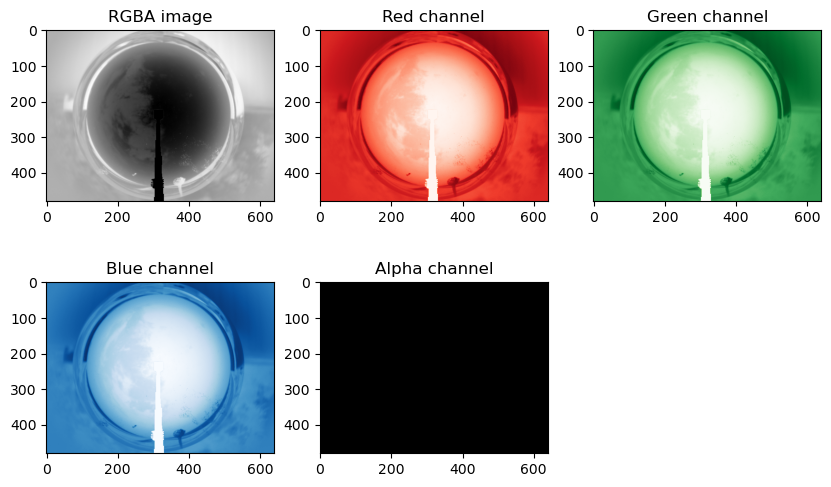

In [168]:
# The following function can be used to generate an RGBA image
def TwoDToRGBA (img):
    # Inputs to blend_modes need to be numpy arrays.
    background_img = np.array(img)  
    # Rescale the pixel values to the range [0, 255]
    scaled_img = ((background_img - np.min(background_img)) / (np.max(background_img) - np.min(background_img)) * 255).astype(np.uint8)
    # Creates an RGBA zeros image with the rescaled content
    rgba_image = np.zeros((background_img.shape[0], background_img.shape[1], 4), dtype=np.uint8)
    # The rescaled values get copied to every channel
    rgba_image[:, :, 0:3] = scaled_img[:, :, np.newaxis]
    # The alpha channel is set to a constant value of 255, for a fully opaque channel
    alpha_value = 255
    rgba_image[:, :, 3] = alpha_value
    # Now 'rgba_image' is an RGBA image with dimensions (~, ~, 4)
    return rgba_image

rgba_image = TwoDToRGBA (img)
print(rgba_image.shape)

plt.figure(figsize=(10,6))
plt.subplot(2, 3, 1)
plt.imshow(rgba_image)
plt.title("RGBA image")

plt.subplot(2, 3, 2)
plt.imshow(rgba_image[:,:,0], cmap="Reds")
plt.title("Red channel")

plt.subplot(2, 3, 3)
plt.imshow(rgba_image[:,:,1], cmap="Greens")
plt.title("Green channel")

plt.subplot(2, 3, 4)
plt.imshow(rgba_image[:,:,2], cmap="Blues")
plt.title("Blue channel")

plt.subplot(2, 3, 5)
plt.imshow(rgba_image[:,:,3], cmap="gray")
plt.title("Alpha channel")



In [169]:
import blend_modes

def create_radial_gradient(size, center, radius):

    y, x = np.ogrid[:size[0], :size[1]]
    distance = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)
    gradient = 1 - np.clip(distance / radius, 0, 1)
    return gradient

def multiply_with_gradient(image, gradient, opacity):
    # Inputs to blend_modes need to be floats.
    background_img_float = image.astype(float)
    foreground_img_float = gradient.astype(float)
    blended_img_float = blend_modes.multiply(background_img_float, foreground_img_float, opacity)

    # Convert blended image back into PIL image
    blended_img = np.uint8(blended_img_float)  # Image needs to be converted back to uint8 type for PIL handling.
    # blended_img_raw = Image.fromarray(blended_img)  # Note that alpha channels are displayed in black by PIL by default.
    return blended_img

image_size = img.shape
gradient_center = (235, 314)  # Center of the gradient correponding to the center of the camera
gradient_radius = 210  # Radius of the gradient
gradient_1 = create_radial_gradient(image_size, gradient_center, gradient_radius)
rgba_grad_1 = TwoDToRGBA (gradient_1)

gradient_radius = 250  # Radius of the gradient
gradient_2 = create_radial_gradient(image_size, gradient_center, gradient_radius)
rgba_grad_2 = TwoDToRGBA (gradient_2)

first_grad = multiply_with_gradient(rgba_image, rgba_grad_1, 1)
second_grad = multiply_with_gradient(first_grad, rgba_grad_2, 1)


86.162109375


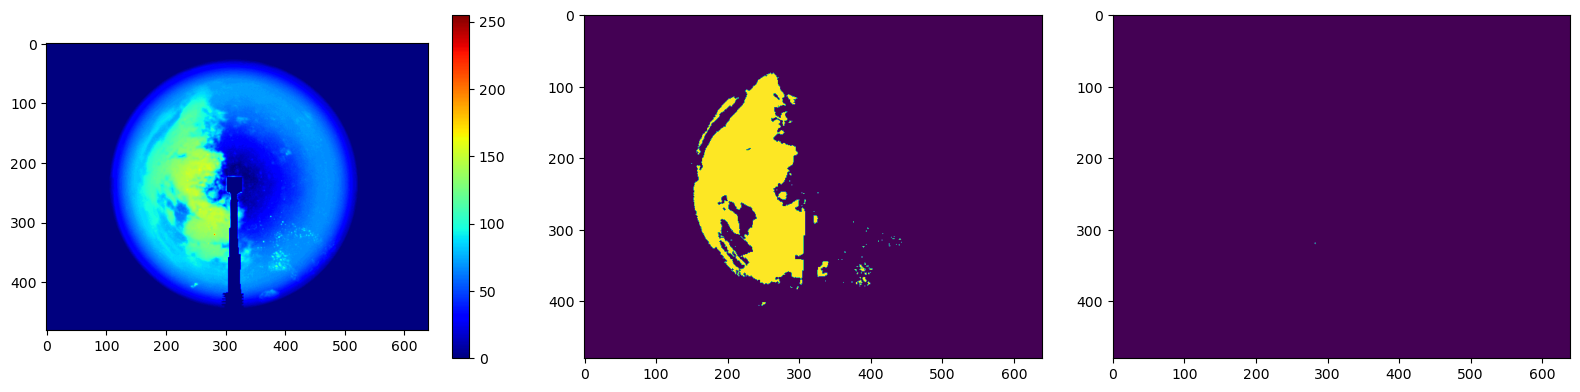

In [170]:
from skimage.filters import threshold_yen, gaussian

gauss = gaussian(first_grad[:,:,0], sigma=0.5)
scaled_img = ((gauss - np.min(gauss)) / (np.max(gauss) - np.min(gauss)) * 255)

thresh  = threshold_yen(scaled_img)
print(thresh)
binary = scaled_img > thresh
# fig, ax = try_all_threshold(scaled_img, figsize=(10, 6), verbose=False)
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(scaled_img, cmap='jet')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(binary)
plt.tight_layout()

plt.subplot(1,3,3)
mask = scaled_img > 180
plt.imshow(mask)
plt.tight_layout()


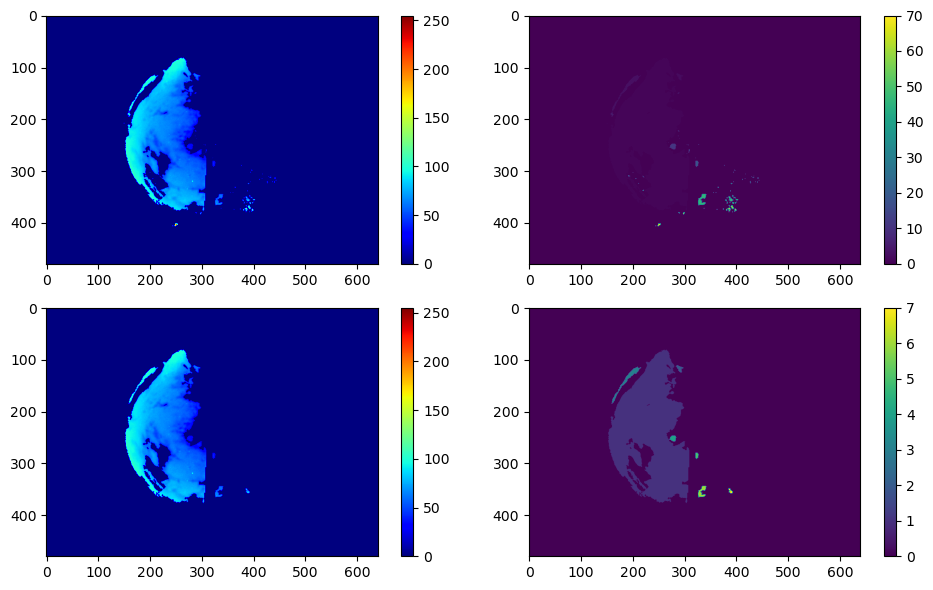

In [171]:
from skimage.measure import label, regionprops
clouds = rgba_image[:,:,0]*binary
cloud_mask= label(binary)

def remove_small(slc, c=0.0001):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1,background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/(640*480) < c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc

big_mask = remove_small(binary)
label_big_mask = label(big_mask)
big_clouds = rgba_image[:,:,0]*big_mask


plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.imshow(clouds, cmap='jet', vmin=0, vmax=255)
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(cloud_mask)
plt.tight_layout()
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(big_clouds, cmap='jet', vmin=0, vmax=255)
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(label_big_mask)
plt.tight_layout()
plt.colorbar()



The whole process to load an image and segment it can be done in a single function. This will be useful for steps below and to implement a single code for the whole feature extraction process. 

Text(0.5, 1.0, '20230807163300.jp2')

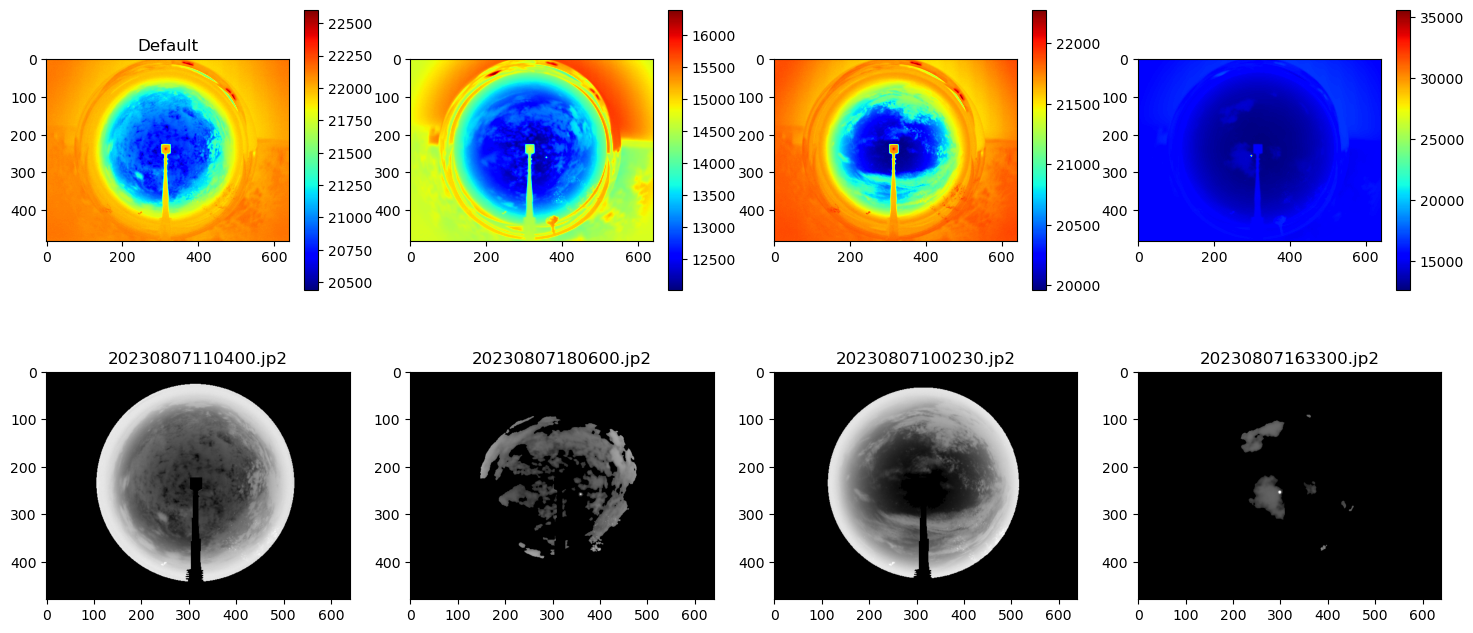

In [172]:
import imageio.v2 as imageio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import blend_modes
from skimage.filters import threshold_yen, gaussian, try_all_threshold
from skimage.measure import label, regionprops
def normalize_img(img):
    gauss = gaussian(img, sigma=20)*2**16-1
    img[img>np.max(gauss)]=np.max(gauss)
    return img
def TwoDToRGBA (img):
    background_img = np.array(img)  
    # Rescale the pixel values to the range [0, 255]
    scaled_img = ((background_img - np.min(background_img)) / (np.max(background_img) - np.min(background_img)) * 255).astype(np.uint8)
    # Creates an RGBA zeros image with the rescaled content
    rgba_image = np.zeros((background_img.shape[0], background_img.shape[1], 4), dtype=np.uint8)
    # The rescaled values get copied to every channel
    rgba_image[:, :, 0:3] = scaled_img[:, :, np.newaxis]
    # The alpha channel is set to a constant value of 255, for a fully opaque channel
    alpha_value = 255
    rgba_image[:, :, 3] = alpha_value
    # Now 'rgba_image' is an RGBA image with dimensions (~, ~, 4)
    return rgba_image
def TwoDToRGB(img):
    background_img = np.array(img)
    # Rescale the pixel values to the range [0, 255]
    scaled_img = ((background_img - np.min(background_img)) / (np.max(background_img) - np.min(background_img)) * 255).astype(np.uint8)
    # Create an RGB image with the rescaled content
    rgb_image = np.zeros((background_img.shape[0], background_img.shape[1], 3), dtype=np.uint8)
    # Copy the rescaled values to all three channels (RGB)
    rgb_image[:, :, :] = scaled_img[:, :, np.newaxis]
    # Now 'rgb_image' is an RGB image with dimensions (height, width, 3)
    return rgb_image
def remove_small(slc, c=0.0001):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1,background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/(640*480) < c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc
def create_radial_gradient(size, center, radius):
    y, x = np.ogrid[:size[0], :size[1]]
    distance = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)
    gradient = 1 - np.clip(distance / radius, 0, 1)
    return gradient
def multiply_with_gradient(image, gradient, opacity):
    background_img_float = image.astype(float)
    foreground_img_float = gradient.astype(float)
    blended_img_float = blend_modes.multiply(background_img_float, foreground_img_float, opacity)
    # Convert blended image back into PIL image
    blended_img = np.uint8(blended_img_float)
    return blended_img
def segmentation(filepath): 
    # Read the JP2 image
    image = imageio.imread(filepath)
    gauss = gaussian(image, sigma=20)*2**16-1
    image[image>np.max(gauss)]=np.max(gauss)
    # Image gets converted to int32
    int_img = image.astype(int)
    # # camera mask is multiplied to the image to make it the darkest part of it by -1
    camara = Image.open('camera.png')
    camara = np.asarray(camara)
    # Only the alpha channel is needed, and is divided by 255 to get the number in the range [0,1]
    slicee = camara[:,:,3]/255
    img = int_img * slicee
    img[img<1000] = np.max(np.min(int_img) - 1, 0)
    rgba_image = TwoDToRGBA (img)
    image_size = img.shape
    gradient_center = (235, 314)  # Center of the gradient correponding to the center of the camera
    gradient_radius = 210  # Radius of the gradient
    gradient_1 = create_radial_gradient(image_size, gradient_center, gradient_radius)
    rgba_grad_1 = TwoDToRGBA (gradient_1)
    gradient_radius = 250  # Radius of the gradient
    gradient_2 = create_radial_gradient(image_size, gradient_center, gradient_radius)
    rgba_grad_2 = TwoDToRGBA (gradient_2)
    first_grad = multiply_with_gradient(rgba_image, rgba_grad_1, 1)
    second_grad = multiply_with_gradient(first_grad, rgba_grad_2, 1)
    gauss = gaussian(first_grad[:,:,0], sigma=0.8)
    scaled_img = ((gauss - np.min(gauss)) / (np.max(gauss) - np.min(gauss)) * 255)
    thresh  = threshold_yen(scaled_img)
    binary = scaled_img > thresh
    big_mask = remove_small(binary)
    label_big_mask = label(big_mask)
    big_clouds = rgba_image[:,:,0]*big_mask


    # For ease of use the single channel image gets converted to RGB (similar to the RGBA process)
    output_img = TwoDToRGB(big_clouds)


    return output_img

# path to jp2 image

def jp2viewer (name):
    path = '20230807/' + name + '.jp2'
    image = imageio.imread(path)
    segmeneted = segmentation(path)
    return image, segmeneted, name + '.jp2'
    
# image1, segmented1, name1 = jp2viewer('20230807180530')
image1, segmented1, name1 = jp2viewer('20230807110400')
image2, segmented2, name2 = jp2viewer('20230807180600')
image3, segmented3, name3 = jp2viewer('20230807100230')
image4, segmented4, name4 = jp2viewer('20230807163300')

plt.figure(figsize=(18,8))
plt.subplot(2,4,1)
plt.imshow(image1, cmap='jet')
plt.title("Default")
plt.colorbar()
plt.subplot(2,4,2)
plt.imshow(image2, cmap='jet')
plt.colorbar()
plt.subplot(2,4,3)
plt.imshow(image3, cmap='jet')
plt.colorbar()
plt.subplot(2,4,4)
plt.imshow(image4, cmap='jet')
plt.colorbar()
plt.subplot(2,4,5)
plt.imshow(segmented1)
plt.title(name1)
plt.subplot(2,4,6)
plt.imshow(segmented2)
plt.title(name2)
plt.subplot(2,4,7)
plt.imshow(segmented3)
plt.title(name3)
plt.subplot(2,4,8)
plt.imshow(segmented4)
plt.title(name4)

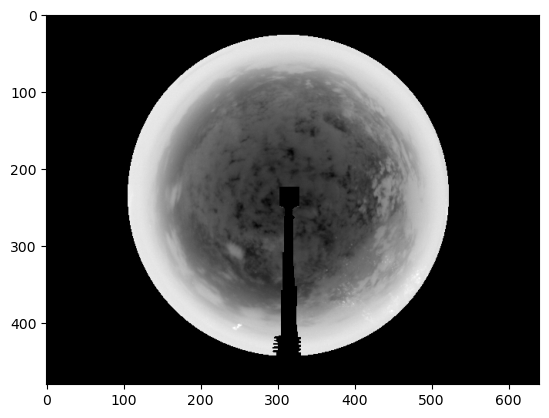

In [173]:
import imageio.v2 as imageio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_yen, gaussian, try_all_threshold

# path to jp2 image
filepath = '20230807/20230807110400.jp2'
# filepath = '20230807/20230807121300.jp2'
# filepath = '20230807/20230807121300.jp2'



image = imageio.imread(filepath)
gauss = gaussian(image, sigma=20)*2**16-1
image[image>np.max(gauss)]=np.max(gauss)
# Image gets converted to int32
int_img = image.astype(int)
# # camera mask is multiplied to the image to make it the darkest part of it by -1
camara = Image.open('camera.png')
camara = np.asarray(camara)
# Only the alpha channel is needed, and is divided by 255 to get the number in the range [0,1]
slicee = camara[:,:,3]/255
img = int_img * slicee
img[img<1000] = np.max(np.min(int_img) - 1, 0)

rgba_image = TwoDToRGBA (img)
image_size = img.shape
gradient_center = (235, 314)  # Center of the gradient correponding to the center of the camera
gradient_radius = 210  # Radius of the gradient
gradient_1 = create_radial_gradient(image_size, gradient_center, gradient_radius)
rgba_grad_1 = TwoDToRGBA (gradient_1)
gradient_radius = 250  # Radius of the gradient
gradient_2 = create_radial_gradient(image_size, gradient_center, gradient_radius)
rgba_grad_2 = TwoDToRGBA (gradient_2)
first_grad = multiply_with_gradient(rgba_image, rgba_grad_1, 1)
second_grad = multiply_with_gradient(first_grad, rgba_grad_2, 1)
gauss = gaussian(first_grad[:,:,0], sigma=0.5)
scaled_img = ((gauss - np.min(gauss)) / (np.max(gauss) - np.min(gauss)) * 255)

# fig, ax = try_all_threshold(scaled_img, figsize=(10, 6), verbose=False)

thresh  = threshold_yen(scaled_img)
binary = scaled_img > thresh

big_mask = remove_small(binary)
label_big_mask = label(big_mask)
big_clouds = rgba_image[:,:,0]*big_mask


# For ease of use the single channel image gets converted to RGB (similar to the RGBA process)
output_img = TwoDToRGB(big_clouds)


plt.imshow(output_img)


180.791015625


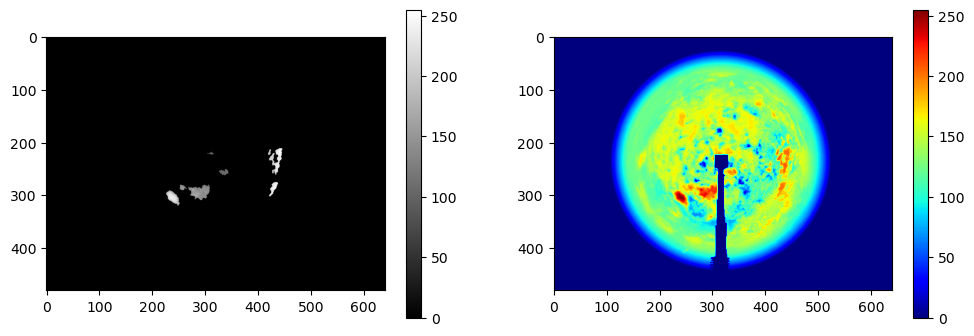

In [199]:
import imageio.v2 as imageio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_yen, gaussian, try_all_threshold
from skimage.metrics import structural_similarity


# path to jp2 image
filepath = '20230807/20230807110330.jp2'
# filepath = '20230807/20230807121300.jp2'
# filepath = '20230807/20230807121300.jp2'



image = imageio.imread(filepath)
gauss = gaussian(image, sigma=20)*2**16-1
image[image>np.max(gauss)]=np.max(gauss)
# Image gets converted to int32
int_img = image.astype(int)
# # camera mask is multiplied to the image to make it the darkest part of it by -1
camara = Image.open('camera.png')
camara = np.asarray(camara)
# Only the alpha channel is needed, and is divided by 255 to get the number in the range [0,1]
slicee = camara[:,:,3]/255
img = int_img * slicee
img[img<1000] = np.max(np.min(int_img) - 1, 0)

rgba_image = TwoDToRGBA (img)
image_size = img.shape
gradient_center = (235, 314)  # Center of the gradient correponding to the center of the camera
gradient_radius = 210  # Radius of the gradient
gradient_1 = create_radial_gradient(image_size, gradient_center, gradient_radius)
rgba_grad_1 = TwoDToRGBA (gradient_1)
gradient_radius = 250  # Radius of the gradient
gradient_2 = create_radial_gradient(image_size, gradient_center, gradient_radius)
rgba_grad_2 = TwoDToRGBA (gradient_2)
first_grad = multiply_with_gradient(rgba_image, rgba_grad_1, 1)
second_grad = multiply_with_gradient(first_grad, rgba_grad_2, 1)
gauss = gaussian(first_grad[:,:,0], sigma=0.5)
scaled_img = ((gauss - np.min(gauss)) / (np.max(gauss) - np.min(gauss)) * 255)

# fig, ax = try_all_threshold(scaled_img, figsize=(10, 6), verbose=False)

thresh  = threshold_yen(scaled_img)
binary = scaled_img > thresh

print(thresh)


big_mask = remove_small(binary)
label_big_mask = label(big_mask)
big_clouds = rgba_image[:, :, 0] * big_mask

# For ease of use the single channel image gets converted to RGB (similar to the RGBA process)
output_img = TwoDToRGB(big_clouds)

# White circle
shape = (480, 640); center = (235, 314); radius = 200
y, x = np.ogrid[:shape[0], :shape[1]]
circle = (x - center[1]) ** 2 + (y - center[0]) ** 2 <= radius ** 2
white_intensity = np.max(output_img)
circle_image = white_intensity * circle


def calculate_similarity_with_white_circle(output_img):
    # Use structural similarity index to measure similarity
    similarity_index = structural_similarity(output_img, circle)
    return similarity_index

# Check similarity with a white circle
white_circle_similarity = calculate_similarity_with_white_circle(binary)

# Adjust threshold if similarity is above a certain threshold
if white_circle_similarity > 0.90:  # Adjust this threshold as needed
    # Increase or decrease the threshold value accordingly
    thresh = thresh + 120 # You can adjust the multiplier based on your observations
    # Apply the threshold again
    binary = scaled_img > thresh

    big_mask = remove_small(binary)
    label_big_mask = label(big_mask)
    big_clouds = rgba_image[:, :, 0] * big_mask

    # For ease of use the single channel image gets converted to RGB (similar to the RGBA process)
    output_img = TwoDToRGB(big_clouds)




plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(output_img, cmap='gray')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(scaled_img, cmap='jet')
plt.colorbar()



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


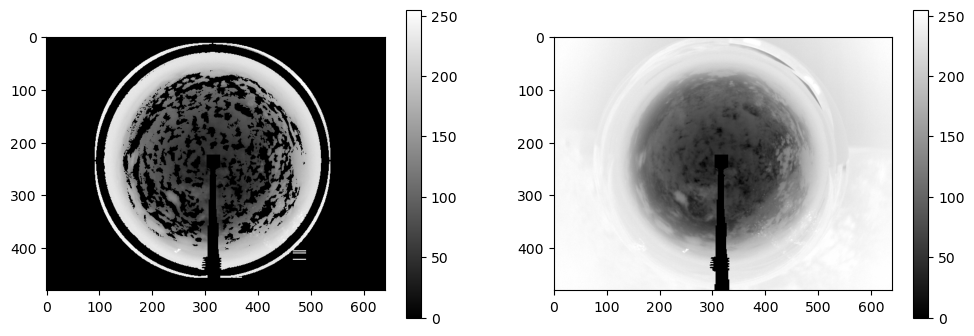

In [212]:
import imageio.v2 as imageio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import *
from skimage.metrics import structural_similarity


# path to jp2 image
filepath = '20230807/20230807110330.jp2'
# filepath = '20230807/20230807121300.jp2'
# filepath = '20230807/20230807121300.jp2'



image = imageio.imread(filepath)
gauss = gaussian(image, sigma=20)*2**16-1
image[image>np.max(gauss)]=np.max(gauss)
# Image gets converted to int32
int_img = image.astype(int)
# # camera mask is multiplied to the image to make it the darkest part of it by -1
camara = Image.open('camera.png')
camara = np.asarray(camara)
# Only the alpha channel is needed, and is divided by 255 to get the number in the range [0,1]
slicee = camara[:,:,3]/255
img = int_img * slicee
img[img<1000] = np.max(np.min(int_img) - 1, 0)

rgba_image = TwoDToRGBA (img)
image_size = img.shape
gradient_center = (235, 314)  # Center of the gradient correponding to the center of the camera
gradient_radius = 210  # Radius of the gradient
gradient_1 = create_radial_gradient(image_size, gradient_center, gradient_radius)
rgba_grad_1 = TwoDToRGBA (gradient_1)
gradient_radius = 250  # Radius of the gradient
gradient_2 = create_radial_gradient(image_size, gradient_center, gradient_radius)
rgba_grad_2 = TwoDToRGBA (gradient_2)
first_grad = multiply_with_gradient(rgba_image, rgba_grad_1, 1)
second_grad = multiply_with_gradient(first_grad, rgba_grad_2, 1)
gauss = gaussian(first_grad[:,:,0], sigma=0.5)
scaled_img = ((gauss - np.min(gauss)) / (np.max(gauss) - np.min(gauss)) * 255)

# fig, ax = try_all_threshold(scaled_img, figsize=(10, 6), verbose=False)
window_size=25
thresh  = threshold_niblack(scaled_img, window_size=window_size, k=0.2)
binary = scaled_img > thresh
print(thresh)

big_mask = remove_small(binary)
label_big_mask = label(big_mask)
big_clouds = rgba_image[:, :, 0] * big_mask

# For ease of use the single channel image gets converted to RGB (similar to the RGBA process)
output_img = TwoDToRGB(big_clouds)


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(output_img, cmap='gray')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(rgba_image, cmap='gray')
plt.colorbar()



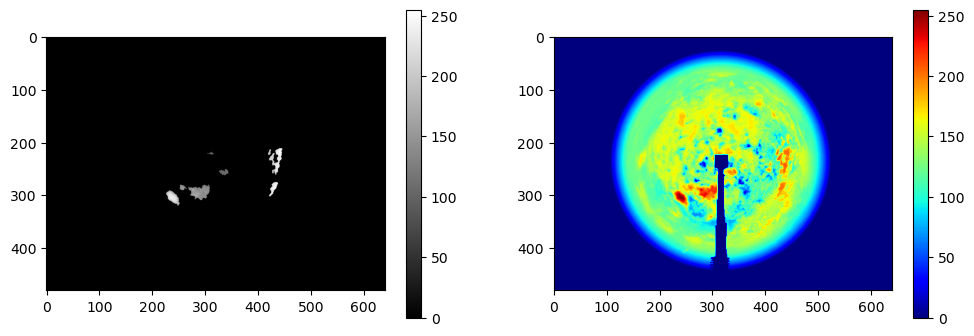

In [226]:
import imageio.v2 as imageio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_yen, gaussian, try_all_threshold
from skimage.metrics import structural_similarity


# path to jp2 image
filepath = '20230807/20230807110400.jp2'
filepath = '20230807/20230807110330.jp2'
# filepath = '20230807/20230807121300.jp2'
# filepath = '20230807/20230807121300.jp2'



image = imageio.imread(filepath)
gauss = gaussian(image, sigma=20)*2**16-1
image[image>np.max(gauss)]=np.max(gauss)
# Image gets converted to int32
int_img = image.astype(int)
# # camera mask is multiplied to the image to make it the darkest part of it by -1
camara = Image.open('camera.png')
camara = np.asarray(camara)
# Only the alpha channel is needed, and is divided by 255 to get the number in the range [0,1]
slicee = camara[:,:,3]/255
img = int_img * slicee
img[img<1000] = np.max(np.min(int_img) - 1, 0)

rgba_image = TwoDToRGBA (img)
image_size = img.shape
gradient_center = (235, 314)  # Center of the gradient correponding to the center of the camera
gradient_radius = 210  # Radius of the gradient
gradient_1 = create_radial_gradient(image_size, gradient_center, gradient_radius)
rgba_grad_1 = TwoDToRGBA (gradient_1)
gradient_radius = 250  # Radius of the gradient
gradient_2 = create_radial_gradient(image_size, gradient_center, gradient_radius)
rgba_grad_2 = TwoDToRGBA (gradient_2)
first_grad = multiply_with_gradient(rgba_image, rgba_grad_1, 1)
second_grad = multiply_with_gradient(first_grad, rgba_grad_2, 1)
gauss = gaussian(first_grad[:,:,0], sigma=0.5)
scaled_img = ((gauss - np.min(gauss)) / (np.max(gauss) - np.min(gauss)) * 255)

# fig, ax = try_all_threshold(scaled_img, figsize=(10, 6), verbose=False)

thresh  = threshold_yen(scaled_img)
binary = scaled_img > thresh

big_mask = remove_small(binary)
label_big_mask = label(big_mask)
big_clouds = rgba_image[:, :, 0] * big_mask

# For ease of use the single channel image gets converted to RGB (similar to the RGBA process)
output_img = TwoDToRGB(big_clouds)

# White circle
shape = (480, 640); center = (235, 314); radius = 200
y, x = np.ogrid[:shape[0], :shape[1]]
circle = (x - center[1]) ** 2 + (y - center[0]) ** 2 <= radius ** 2
white_intensity = np.max(output_img)
circle_image = white_intensity * circle


def calculate_similarity_with_white_circle(output_img):
    # Use structural similarity index to measure similarity
    similarity_index = structural_similarity(output_img, circle)
    return similarity_index

# Check similarity with a white circle
white_circle_similarity = calculate_similarity_with_white_circle(binary)

# Adjust threshold if similarity is above a certain threshold
if white_circle_similarity > 0.90:  # Adjust this threshold as needed
    window_size=25
    thresh  = threshold_niblack(scaled_img, window_size=window_size, k=0.2)
    binary = scaled_img > thresh
    print(thresh)

    big_mask = remove_small(binary)
    label_big_mask = label(big_mask)
    big_clouds = rgba_image[:, :, 0] * big_mask

    # For ease of use the single channel image gets converted to RGB (similar to the RGBA process)
    output_img = TwoDToRGB(big_clouds)


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(output_img, cmap='gray')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(scaled_img, cmap='jet')
plt.colorbar()

